# Intensity distribution estimation through mixture models

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("..")) # so we can find didson.py, multibeam.py

from glob import glob           # file manipulation
import numpy as np
from skimage.io import imread   # image processing
from scipy.optimize import curve_fit
from scipy.stats import *       # stats utils

from matplotlib import rcParams 

rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Latin Modern Math']
print rcParams['font.size']
import matplotlib.pyplot as plt
%matplotlib inline

10.0


In [2]:
from sonar import Sonar
from didson import Didson

didson = Didson();
didson.loadConfig('../data/DIDSON/didson.json')
print 'Pings are',didson.num_beams,'beams by',didson.num_bins, 'bins'
print 'Field of view:', didson.fov
print 'Range:', didson.min_range, ' - ', didson.max_range, 'm.'
print 'Noise:', didson.noise
print 'RX gain:', didson.rx_gain,'dB'

Pings are 96 beams by 512 bins
Field of view: 0.502654824574
Range: 2.25  -  11.25 m.
Noise: 0.002
RX gain: 20.0 dB


## utility functions

In [3]:
def compile(image_list, cfg_list, sonar,enhance=False):
    # horizontally stacks a set of images  (512 rows by (Nx96) columns)
    N = len(image_list)
    data = imread(image_list[0],as_grey=True).astype(np.float64) # 0-255.0
    for i in range(1,N):
        ping = imread(image_list[i],as_grey=True).astype(np.float64) # 0-255.0
        if(enhance):
            sonar.loadConfig(cfg_list[i])
            sonar.noise = 0.01
            ping = sonar.deconvolve(ping)
            ping = sonar.removeTaper(ping)
        data = np.hstack((data,ping))   

    data/=255.0

    return data

In [4]:
def kld(sample, reference):
    p = sample
    q = reference    
    q[np.where(q==0)[0]] = 1 # we're dividing by q, so set all zero-values to 1
    r = p/q
    r[np.where(r==0)[0]] = 1 # ln(1) = 0; ln(0)=nan

    return np.sum(p*np.log(r)) # kld wrt background

## Background distribution

### Load background data set

In [5]:
bg_image_list = glob('../data/background/*.png') # window set to 2.25m to 11.25m
bg_config_list = glob('../data/background/*.json')
print len(bg_image_list),'image files,',len(bg_config_list),'config files'

116 image files, 116 config files


In [6]:
bg_data = compile(bg_image_list, bg_config_list, didson, True)
bins = np.linspace(0,1.0,256)
h_bg = np.histogram(bg_data.flatten(),bins)
h_bg = h_bg[0]/(np.sum(h_bg[0])+0.0)     # normalize
print len(bg_data.flatten())

5701632


### Fit mixture model

pi: 0.31177466521 , s1: 0.0223247718437  (lambda: 44.7932909237 )
kld: 0.000384820920568
sum: 1.0


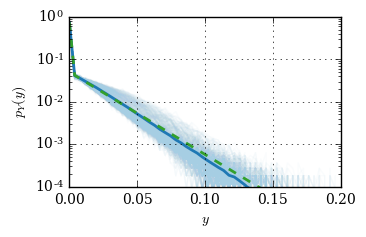

In [7]:
def bg_mixture(x, pi, s):
    # background distribution as an exponential with zero-bias
    p1 = expon.pdf(x,0,s)
    p1/=np.sum(p1)
    p1*=pi
    p = p1
    p[0] += (1-pi)
    return p

x = bins[:-1]
p, v = curve_fit(bg_mixture, x, h_bg, p0=[0.5, 2e-2])

print 'pi:',p[0],', s1:',p[1],' (lambda:',1.0/p[1],')'
bg_est = bg_mixture(x, p[0], p[1])
print 'kld:',kld(h_bg, bg_est)
print 'sum:',np.sum(bg_est)

plt.figure(figsize=(3.5,3.5*5/8.0))
for i in range(0,512):
    hi = np.histogram(bg_data[i,:],bins)
    plt.plot(bins[:-1],hi[0]/(np.sum(hi[0])+0.0),color='#a6cee3',alpha=0.05)

plt.plot(x, h_bg,'-',color='#1f78b4',linewidth=2.0)
# plt.plot(x, bg_est,'--',color='#b2df8a',linewidth=2.0)
plt.plot(x, bg_est,'--',color='#33a02c',linewidth=2.0)
plt.yscale('log')
plt.ylabel('$p_Y(y)$')
plt.xlabel('$y$')
plt.ylim([1e-4,1e0])
plt.xlim([0,.2])
plt.grid()
plt.savefig('background_mixture.pdf',dpi=600,bbox_inches='tight',transparent=True,pad_inches=0.02) # no transparency on eps!


## Object intensity distribution (aggregate)

### Load test data set

In [8]:
test_image_list = glob('../data/test/*.png') # window set to 2.25m to 11.25m
print len(test_image_list),'image files'
test_config_list = glob('../data/test/*.json')
print len(test_config_list),'config files'

10 image files
10 config files


In [9]:
test_data = compile(test_image_list, test_config_list, didson, True)
bins = np.linspace(0,1.0,256)
h_test = np.histogram(test_data.flatten(),bins)
h_test = h_test[0]/(np.sum(h_test[0])+0.0)     # normalize
print len(test_data.flatten())

491520


### Fit mixture model

pi1=0.311, l1= 0.021
pi2=0.030, l2= 0.125
pi0=0.658
kld: 0.00483457828331


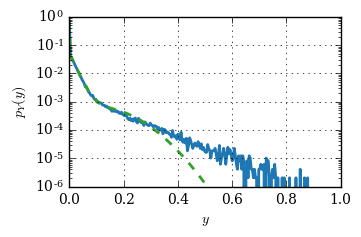

In [10]:
def mixture(x, pi1, pi2, l1, l2):
    # zero bias
    p0 = np.zeros_like(x)
    p0[0]=1
    
    # background
    p1 = expon.pdf(x,0,l1)
    p1/=np.sum(p1)
    
    # object
#     p2 = expon.pdf(x,0,l2)
    p2 = rayleigh.pdf(x,0,l2)
    p2/=np.sum(p2)
    
    # mixture
    p = (1-pi1-pi2)*p0 + pi1*p1 + pi2*p2
#     print np.sum(p)
    p/=np.sum(p)
    return p

x = bins[:-1]
p, v = curve_fit(mixture, x, h_test, p0=[0.3, 0.02, 0.02, 0.15])

print('pi1=%.3f, l1= %.3f' % (p[0], p[2]))
print('pi2=%.3f, l2= %.3f' % (p[1], p[3]))
print('pi0=%.3f' % (1-p[0]-p[1]))
p_test = mixture(x,p[0],p[1],p[2],p[3])
print 'kld:', kld(h_test, p_test)

plt.figure(figsize=(3.5,3.5*5/8.0))
# for i in range(0,512):
#     hi = np.histogram(test_data[i,:],bins)
#     plt.plot(bins[:-1],hi[0]/(np.sum(hi[0])+0.0),'.',color='#a6cee3',alpha=0.05)

plt.plot(x, h_test,'-',color='#1f78b4',linewidth=2.0)
# plt.plot(x, bg_est,'--',color='#b2df8a',linewidth=2.0)
plt.plot(x, p_test,'--',color='#33a02c',linewidth=2.0)
plt.yscale('log')
plt.ylabel('$p_Y(y)$')
plt.xlabel('$y$')
plt.ylim([1e-6,1e0])
plt.xlim([0,1.0])
plt.grid()
plt.savefig('test_mixture.pdf',dpi=600,bbox_inches='tight',transparent=True,pad_inches=0.02) # no transparency on eps!


## Object intensity distribution (individual images)

In [11]:
def background(x, pi1, pi2, l1, l2):
    # zero bias
    p0 = np.zeros_like(x)
    p0[0]=1
    
    # background
    p1 = expon.pdf(x,0,l1)
    p1/=np.sum(p1)
    
    # object
#     p2 = expon.pdf(x,0,l2)
    p2 = rayleigh.pdf(x,0,l2)
    p2/=np.sum(p2)
    
    # mixture
    p = (1-pi1-pi2)*p0 + pi1*p1 + pi2*p2
#     print np.sum(p)
    p/=np.sum(p)
    return p

0 & shaft & 0.317 & 43.124 & 0.014 & 0.171 & 0.003227 \\ \hline
1 & rudder & 0.322 & 56.020 & 0.000 & 0.387 & 0.007851 \\ \hline
2 & hull & 0.306 & 49.483 & 0.012 & 0.180 & 0.003006 \\ \hline
3 & fish & 0.301 & 39.397 & 0.013 & 0.140 & 0.002099 \\ \hline
4 & propeller & 0.271 & 30.175 & 0.098 & 0.139 & 0.013194 \\ \hline
5 & hull & 0.298 & 78.343 & 0.019 & 0.095 & 0.001803 \\ \hline
6 & fish & 0.309 & 40.475 & 0.013 & 0.160 & 0.002117 \\ \hline
7 & fish & 0.302 & 43.878 & 0.014 & 0.141 & 0.002079 \\ \hline
8 & hull & 0.321 & 37.375 & 0.009 & 0.215 & 0.002451 \\ \hline
9 & fish, seafloor & 0.301 & 57.096 & 0.019 & 0.134 & 0.002616 \\ \hline


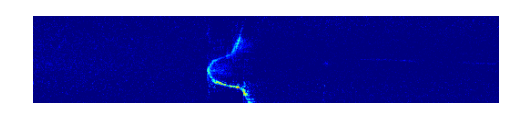

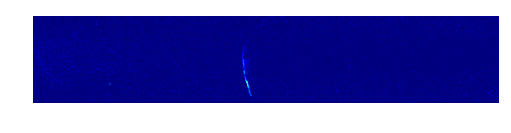

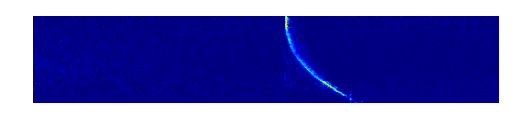

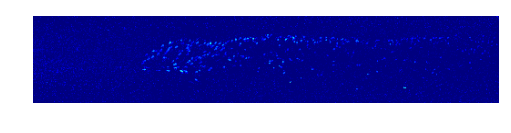

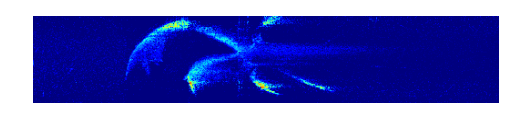

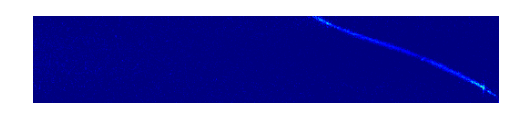

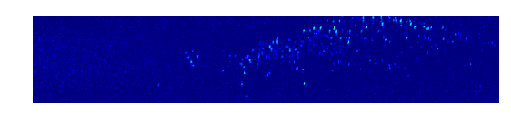

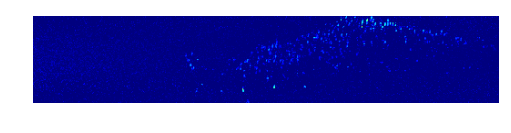

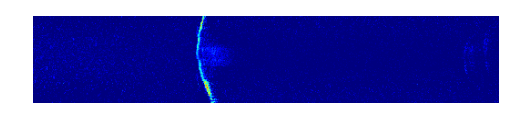

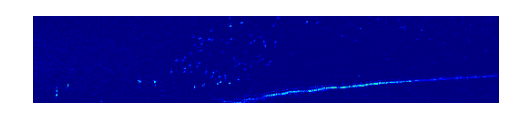

In [17]:
rcParams['font.size'] = 4

description=('shaft','rudder','hull','fish','propeller','hull','fish','fish','hull','fish, seafloor')

pi1 = np.zeros(10)
pi2 = np.zeros(10)
s1  = np.zeros(10) # 1/lambda 
s2  = np.zeros(10) # sigma

for idx in range(0,len(test_image_list)):
    image = (1/255.0)*imread(test_image_list[idx],as_grey = True)
    didson.loadConfig(test_config_list[idx])
    image = didson.deconvolve(image)
    image = didson.removeTaper(image)
    
    plt.figure()
    plt.imshow(image.transpose(),vmin=0,vmax=1)
    plt.axis('off')
    
    bins = np.linspace(0, 1.0, 256 )
    hi = np.histogram(image[:],bins)
    
    x = hi[1][:-1].astype(np.float64)
    h_test = hi[0][:].astype(np.float64)
    h_test/=(0.0+np.sum(h_test))
    
    try:
        p, v = curve_fit(mixture, x, h_test, p0=[0.3, 0.02, 0.02, 0.15],bounds=([0,0,0.0,0],[0.5,0.5,1.0,1.0]))
#         print 'pi1:', p[0], 'l1:',p[2]
#         print('pi1=%.3f, l1= %.3f' % (p[0], 1.0/p[2]))
#         print 'pi2:', p[1], 'l2:',p[3]
#         print('pi2=%.3f, l2= %.3f' % (p[1], 1.0/p[3]))
#         print('pi0=%.3f' % (1-p[0]-p[1]))
        p_test = mixture(x,p[0],p[1],p[2],p[3])
        kldv = kld(h_test, p_test)
        print idx,'&',description[idx],('& %.3f & %.3f & %.3f & %.3f & %.6f \\\\ \\hline' % ( p[0], 1.0/p[2], p[1], p[3], kldv))
        pi1[idx] = p[0]
        s1[idx]  = p[2]
        pi2[idx] = p[1]
        s2[idx]  = p[3]
    except RuntimeError:
        print 'FAILED!'
        continue

#     plt.figure(figsize=(2.4,0.45))
#     plt.plot(x, h_test,color='#1f78b4',alpha=0.8,linewidth=0.5)
#     plt.plot(x, p_test,color='#33a02c',alpha=0.8,linewidth=0.5)
#     plt.xlim([0,1])
#     plt.ylim([1e-5,1e0])
#     plt.xlabel('$y$')
#     plt.ylabel('$p_Y(y)$')    
#     plt.yscale('log')
#     plt.grid(linewidth=.2,linestyle='-',alpha=0.5)
#     ax = plt.gca()
#     for side in ('top','bottom','left','right'):
#         ax.spines[side].set_linewidth(0.2)
#     ax.tick_params(width=0.2)    
#     plt.minorticks_off()
#     plt.savefig('test_mixture_'+str(idx)+'.pdf',dpi=600,bbox_inches='tight',transparent=True,pad_inches=0.02) # no transparency on eps!

rcParams['font.size'] = 10 # default value

## ROC curve(s)

In [13]:
def background_pmf(x, pi1, l1):
    # zero bias
    p0 = np.zeros_like(x)
    p0[0]=1
    
    # background
    p1 = expon.pdf(x,0,l1)
    p1/=np.sum(p1)
    
    # mixture
    p = (1-pi1)*p0 + pi1*p1
    p/=np.sum(p)
    return p

def object_pmf(x, l):
    # object
    p = rayleigh.pdf(x,0,l)
    p/=np.sum(p)
    return p

(1e-05, 1)

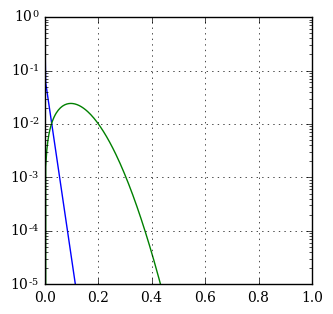

In [14]:
# 4 - propeller
# pmf_bg = background_pmf(x, .300, 1.0/30.2 )
# pmf_o  = object_pmf(x, 0.139)

# 5 - hull
pmf_bg = background_pmf(x, .304, 1.0/78.3 )
pmf_o  = object_pmf(x, 0.098)

plt.figure(figsize=(3.45,3.45))
plt.plot(x, pmf_bg)
plt.plot(x, pmf_o)
plt.yscale('log')
plt.grid()
plt.ylim([1e-5,1])

### intensity threshold decision rule

/home/pvt/miniconda2/envs/multibeam/lib/python2.7/site-packages/matplotlib/axes/_base.py:1327: UserWarning: aspect is not supported for Axes with xscale=log, yscale=linear
  'yscale=%s' % (xscale, yscale))


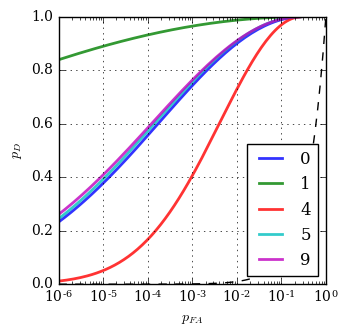

In [15]:

# ROC curve for intensity threshold decision rule
plt.figure(figsize=(3.45,3.45))
indices = (0,1,4,5,9)

for i in indices:
    p_bg = pi1[i]/(1-pi2[i])
    pmf_bg = background_pmf(x, p_bg, s1[i] )
    pmf_o  = object_pmf(x, s2[i])
    p_fa = 1 - np.cumsum(pmf_bg)
    p_d  = 1 - np.cumsum(pmf_o)

#     plt.plot(p_fa,p_d,'-',color='#1f78b4',alpha=1.0,linewidth=2.0)
    plt.plot(p_fa,p_d,'-',alpha=0.8,linewidth=2.0)

    
eq = np.logspace(-6,0,100)
plt.plot(eq,eq,'--',color='k')

plt.grid()
plt.xlabel('$p_{FA}$')
plt.ylabel('$p_{D}$')
plt.axis('equal')
plt.xlim([1e-6,1])
plt.ylim([1e-6,1])
plt.xscale('log')
    # plt.yscale('log')
plt.legend(('0','1','4','5','9'),loc=4)
plt.savefig('roc_5.pdf',dpi=600,bbox_inches='tight',transparent=True,pad_inches=0.02) # no transparency on eps!

### MAP decision rule (likelihood ratio)

In [ ]:
# likelihood ratio (used in the MAP decision rule)
plt.figure(figsize=(3.45,3.45))
plt.plot(x,pmf_o/pmf_bg)
plt.grid()
plt.xlabel('$y$')
plt.ylabel('$\Lambda(y)$')
plt.yscale('log')
plt.xlim([0,1])

In [ ]:
plt.figure(figsize=(3.45,3.45))
plt.plot(x,p_fa)
plt.plot(x,p_d)
plt.xlim([0,0.2])
plt.grid()
plt.legend(('$p_{FA}$','$p_{D}$'))

print p_fa[25:30]
print p_d[25:30]
print x[28]

----

----

----

----

----

----

----

In [ ]:
idx = np.random.randint(0,len(test2_image_list))
# idx = 22162
# idx = 25249
print idx
print test2_image_list[idx]

image = (1/255.0)*imread(test2_image_list[idx],as_grey = True)
didson.loadConfig(test2_config_list[idx])

plt.figure()
plt.imshow(image.transpose(),vmin=0,vmax=1)
plt.axis('off')

image = didson.deconvolve(image)
plt.figure()
plt.imshow(image.transpose(),vmin=0,vmax=1)
plt.axis('off')

image = didson.removeTaper(image)
plt.figure()
plt.imshow(image.transpose(),vmin=0,vmax=1)
plt.axis('off')
plt.savefig('test.png',bbox_inches='tight',transparent=True,pad_inches=0.0)

bins = np.linspace(0, 1.0, 256 )
hi = np.histogram(image[:],bins)
x = hi[1][:-1].astype(np.float64)
h_test = hi[0][:].astype(np.float64)
h_test/=(0.0+np.sum(h_test))
print np.min(h_test), np.max(h_test)

(pi, s, k) = grid_search_fit(x,h_test, 100)
(i_star, j_star) = np.unravel_index(np.argmin(k, axis=None), k.shape)
print 'pi:',pi[i_star]
print 's:',s[j_star]
print 'kld:',k[i_star,j_star]

plt.figure(figsize=(3,3))
plt.plot(s[j_star], pi[i_star], 'x',color='r',ms=5.0,mew=2.0)
plt.imshow(k,extent=(s.min(),s.max(),pi.max(), pi.min()))

plt.figure()
plt.plot(hi[1][:-1],h_test,color='#a6cee3',linewidth=2.0)
plt.plot(hi[1][:-1],p_bg,color='#1f78b4',linewidth=2.0)

# p_o = rayleigh.pdf(x,0,s[j_star])
p_o = expon.pdf(x,0,s[j_star])
p_o/=np.sum(p_o)

# p_bg = bg_mixture(x, 0.312, 22.3e-3 , 61.2e-6)
# print 'p_bg:',np.sum(p_bg)

p_est = pi[i_star]*p_bg + (1-pi[i_star])*p_o
plt.plot(x,p_est,'--',color='#33a02c',linewidth=2.0)

plt.xlim([1e-6,1e0])
plt.ylim([1e-5,1e0])
plt.yscale('log')
plt.xscale('log')

plt.ylabel('$p_Y(y)$')
plt.xlabel('$y$')
plt.grid()



In [ ]:
from sonar import Sonar
from didson import Didson

didson = Didson();
didson.loadConfig('../data/DIDSON/didson.json')
print 'Pings are',didson.num_beams,'beams by',didson.num_bins, 'bins'
print 'Field of view:', didson.fov
print 'Range:', didson.min_range, ' - ', didson.max_range, 'm.'
print 'Noise:', didson.noise

In [ ]:
(pi, s, k) = grid_search_fit(x,h_test, 100)
(i_star, j_star) = np.unravel_index(np.argmin(k, axis=None), k.shape)
print 'pi:',pi[i_star]
print 's:',s[j_star]
print 'kld:',k[i_star,j_star]
s1 = s[j_star]
pi0 = pi[i_star]

p_o = rayleigh.pdf(x,0,s1)
p_o/=np.sum(p_o)
p_approx = pi0*p_bg + (1-pi0)*p_o

# mixture
plt.figure(figsize=(3.45,3.45*5/8.0))
plt.plot(x, p_bg)
plt.plot(x, p_o)
plt.plot(x, h_test)
plt.plot(x, p_approx)
plt.xlim([0,1])
plt.ylim([1e-5,1e0])
plt.yscale('log')
plt.grid()

# grid search
plt.figure(figsize=(3.45,3.45*5/8.0))
plt.plot(s[j_star], pi[i_star], 'x',color='r',ms=5.0,mew=2.0)
plt.imshow(k,extent=(s.min(),s.max(),pi.max(), pi.min()))
plt.colorbar()
# plt.xlabel('')
# plt.ylabel('$\pi$')
plt.savefig('grid_search.eps',dpi=600,bbox_inches='tight',transparent=True)

# ROC

# classified image

In [ ]:
test_image_list = glob('../data/test/*.png') # window set to 2.25m to 11.25m
test_config_list = glob('../data/test/*.json')
print len(test_image_list),'image files,',len(test_config_list),'config files'

# test2_image_list = glob('../data/tank-test/dataset_10_post/pings/raw/*.png') # window set to 2.25m to 11.25m
# print len(test2_image_list),'image files'
# test2_config_list = glob('../data/tank-test/dataset_10_post/pings/cfg/*.json')
# print len(test2_config_list),'config files'

# test2_image_list = glob('../data/2016-07-19.11/raw/*.png') # window set to 2.25m to 11.25m
# print len(test2_image_list),'image files'
# test2_config_list = glob('../data/2016-07-19.11/cfg/*.json')
# print len(test2_config_list),'config files'

In [ ]:
# %%timeit
plt.figure(figsize=(8,10.5))

for idx in range(0,len(test_image_list)):
    image = (1/255.0)*imread(test_image_list[idx],as_grey = True)
    didson.loadConfig(test_config_list[idx])
    
    image = didson.deconvolve(image)
    image = didson.removeTaper(image)
    
    bins = np.linspace(0, 1.0, 256 )
    hi = np.histogram(image[:],bins)
    
    x = hi[1][:-1].astype(np.float64)
    h_test = hi[0][:].astype(np.float64)
    h_test/=(0.0+np.sum(h_test))
    
    (pi, s, k) = grid_search_fit(x,h_test, 10)
    
    (i_star, j_star) = np.unravel_index(np.argmin(k, axis=None), k.shape)
#     print idx, ' - ','pi:',pi[i_star], 's:',s[j_star], 'kld:',k[i_star,j_star]
    print '%d & 50 & %.3f & %.3f & %.3f \\\\ ' % (idx, pi[i_star], s[j_star], k[i_star, j_star]) # latex table

    plt.subplot(len(test_image_list),2,2*idx+1)
    plt.imshow(image.transpose())
    plt.axis('off')

    plt.subplot(len(test_image_list),2,2*idx+2)
    plt.plot(x, h_test,color='k')
    plt.xlim([0,1])
    plt.ylim([1e-5,1e0])
    plt.yscale('log')
    plt.grid()

plt.savefig('test.eps',dpi=600,bbox_inches='tight',transparent=True)


## ROC computation

In [ ]:
x = np.linspace(0,1,100)

p_fa = np.exp(-55.6*x)
p_d = np.exp(-x*x/(2*0.18*0.18))

plt.figure(figsize=(3.45,3.45))
plt.plot(p_fa,p_d)
plt.grid()
plt.xlabel('$p_{FA}$')
plt.ylabel('$p_{D}$')
plt.plot([0,1],[0,1],'--',color='k')
plt.axis('equal')

# plt.yscale('log')
# plt.xscale('log')


In [ ]:
%%timeit

def mix3(x, pi1, pi2, l1, l2):
    # zero bias
    p0 = np.zeros_like(x)
    p0[0]=1
    # background
    p1 = expon.pdf(x,0,l1)
    p1/=np.sum(p1)
    # object
    p2 = expon.pdf(x,0,l2)
    p2/=np.sum(p2)
    # mixture
    p = (1-pi1-pi2)*p0 + pi1*p1 + pi2*p2
#     print np.sum(p)
    p/=np.sum(p)
    
    return p
    
p, v = curve_fit(mix3, x, h_test, p0=[0.3,0.05, 0.01, 0.1])

# print 'pi1:', p[0], 'pi2:', p[1], 'sum:',p[0]+p[1]
# print 'l1:', p[2], 1.0/p[2]
# print 'l2:', p[3], 1.0/p[3]

# pmf_est = mix3(x,p[0],p[1],p[2],p[3])

# print 'kld:',kld(h_test, pmf_est)

# plt.plot(x, h_test)
# plt.plot(x, pmf_est )
# plt.yscale('log')
# plt.grid()
# plt.ylim([1e-6,1])
# plt.xlim([0,1.0])

In [ ]:
def grid_search_fit(x, h_test,N=100):

    pi = np.linspace(0.7, 1.0, N)
    s = np.linspace(1e-3, 1.0, N)
#     s = np.logspace(-8,-3,N)

    k = np.zeros((len(pi),len(s)))
    
    p_bg_1 = expon.pdf(x, 0,22.3e-3 )
    p_bg_1/=np.sum(p_bg_1)
    p_bg_2 = expon.pdf(x, 0,61.2e-6 )
    p_bg_2/=np.sum(p_bg_2)
    p_bg = 0.312*p_bg_1 + (1-0.312)*p_bg_2
    p_bg/=np.sum(p_bg)

    for i in range(0,len(pi)):
        for j in range(0,len(s)):
#             p_o = rayleigh.pdf(x, 0.0, s[j])
            p_o = expon.pdf(x,0.0,s[j])
            p_o/=np.sum(p_o) # discrete pdf has to sum to 1

            p_t = pi[i]*p_bg + (1-pi[i])*p_o
            p_t/=np.sum(p_t)
            k[i,j] = kld(h_test,p_t)

    return(pi, s, k)

In [ ]:
(pi, s, k) = grid_search_fit(x, h_test)
(i_star, j_star) = np.unravel_index(np.argmin(k, axis=None), k.shape)
print 'pi:',pi[i_star]
print 's:',s[j_star]
print 'kld:',k[i_star,j_star]

plt.figure(figsize=(3.45,3.45*5/8.0))
plt.plot(s[j_star], pi[i_star], 'x',color='r',ms=5.0,mew=2.0)
plt.imshow(k,extent=(s.min(),s.max(),pi.max(), pi.min()))
plt.xlabel('$\sigma$')
plt.ylabel('$\pi$')
plt.colorbar()
# plt.xlabel('')
# plt.ylabel('$\pi$')
plt.savefig('grid_search.eps',dpi=600,bbox_inches='tight',transparent=True)

plt.figure(figsize=(3.5,3.5*5/8.0))

plt.plot(bins[:-1],h_bg,color='#a6cee3',linewidth=2.0)
plt.plot(bins[:-1],h_test,color='#1f78b4',linewidth=2.0)
    
# p_o = rayleigh.pdf(x,0,s[j_star])
p_o = expon.pdf(x,0,s[j_star])
p_o/=np.sum(p_o)

p_bg = bg_mixture(x, 0.312, 22.3e-3 , 61.2e-6)
print 'p_bg:',np.sum(p_bg)

p_est = pi[i_star]*p_bg + (1-pi[i_star])*p_o
plt.plot(x,p_est,'--',color='#33a02c',linewidth=2.0)

plt.yscale('log')
plt.xlim([0,1.0])
plt.ylim([1e-6,1])
plt.grid()
plt.ylabel('$p_Y(y)$')
plt.xlabel('$y$')
plt.savefig('test_mixture.pdf',dpi=600,bbox_inches='tight',transparent=True,pad_inches=0.02) # no transparency on eps!
